# RNN Basic

## 1. RNN Model

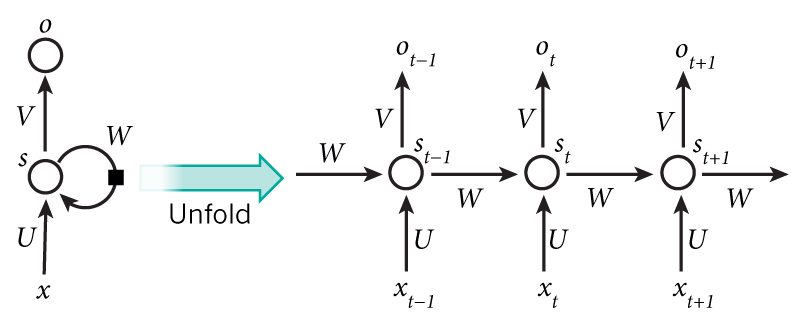

- $s_t = f(Ux_t+Ws_{t-1})$
- $o_t=\text{softmax}(Vs_t)$

**Bidirectional RNN**

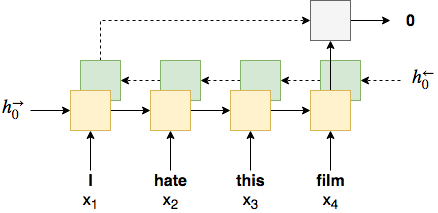

**MUlti-layer RNN**

sentiment4.png

**LSTM**

[관련 자료](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

## 2. Pytorch로 구현해 보기 (MNIST Classification)

**참고**

Pytorch에서 RNN 계열의 input 모양은
- (batch, seq_len, input_size) if batch_first=True
- (seq_len, batch, input_size) if batch_first=False

### 2.1. RNN으로 구현하기

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 5
learning_rate = 0.001

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.0871
Epoch [1/5], Step [200/600], Loss: 0.7211
Epoch [1/5], Step [300/600], Loss: 0.4715
Epoch [1/5], Step [400/600], Loss: 0.4059
Epoch [1/5], Step [500/600], Loss: 0.5336
Epoch [1/5], Step [600/600], Loss: 0.4128
Epoch [2/5], Step [100/600], Loss: 0.3412
Epoch [2/5], Step [200/600], Loss: 0.2525
Epoch [2/5], Step [300/600], Loss: 0.1651
Epoch [2/5], Step [400/600], Loss: 0.2384
Epoch [2/5], Step [500/600], Loss: 0.2666
Epoch [2/5], Step [600/600], Loss: 0.1479
Epoch [3/5], Step [100/600], Loss: 0.2399
Epoch [3/5], Step [200/600], Loss: 0.2516
Epoch [3/5], Step [300/600], Loss: 0.1956
Epoch [3/5], Step [400/600], Loss: 0.1344
Epoch [3/5], Step [500/600], Loss: 0.1911
Epoch [3/5], Step [600/600], Loss: 0.3732
Epoch [4/5], Step [100/600], Loss: 0.0890
Epoch [4/5], Step [200/600], Loss: 0.1059
Epoch [4/5], Step [300/600], Loss: 0.1753
Epoch [4/5], Step [400/600], Loss: 0.0870
Epoch [4/5], Step [500/600], Loss: 0.1537
Epoch [4/5], Step [600/600], Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 96.64 %


### 2.2 LSTM으로 구현하기 (연습)

[Pytorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [ ]:
# Recurrent neural network (many-to-one)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = None
        c0 = None
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.7349
Epoch [1/5], Step [200/600], Loss: 0.4935
Epoch [1/5], Step [300/600], Loss: 0.2149
Epoch [1/5], Step [400/600], Loss: 0.1746
Epoch [1/5], Step [500/600], Loss: 0.1574
Epoch [1/5], Step [600/600], Loss: 0.0682
Epoch [2/5], Step [100/600], Loss: 0.2107
Epoch [2/5], Step [200/600], Loss: 0.0964
Epoch [2/5], Step [300/600], Loss: 0.1933
Epoch [2/5], Step [400/600], Loss: 0.1079
Epoch [2/5], Step [500/600], Loss: 0.0419
Epoch [2/5], Step [600/600], Loss: 0.0224
Epoch [3/5], Step [100/600], Loss: 0.0772
Epoch [3/5], Step [200/600], Loss: 0.0425
Epoch [3/5], Step [300/600], Loss: 0.0622
Epoch [3/5], Step [400/600], Loss: 0.0810
Epoch [3/5], Step [500/600], Loss: 0.2023
Epoch [3/5], Step [600/600], Loss: 0.0219
Epoch [4/5], Step [100/600], Loss: 0.0849
Epoch [4/5], Step [200/600], Loss: 0.0761
Epoch [4/5], Step [300/600], Loss: 0.0335
Epoch [4/5], Step [400/600], Loss: 0.0855
Epoch [4/5], Step [500/600], Loss: 0.0607
Epoch [4/5], Step [600/600], Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 98.52 %


Bidirectional LSTM 구현해 보기

In [ ]:
# Recurrent neural network (many-to-one)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.7251
Epoch [1/5], Step [200/600], Loss: 0.2304
Epoch [1/5], Step [300/600], Loss: 0.2852
Epoch [1/5], Step [400/600], Loss: 0.1629
Epoch [1/5], Step [500/600], Loss: 0.2092
Epoch [1/5], Step [600/600], Loss: 0.1710
Epoch [2/5], Step [100/600], Loss: 0.1594
Epoch [2/5], Step [200/600], Loss: 0.0493
Epoch [2/5], Step [300/600], Loss: 0.2251
Epoch [2/5], Step [400/600], Loss: 0.1307
Epoch [2/5], Step [500/600], Loss: 0.1594
Epoch [2/5], Step [600/600], Loss: 0.0958
Epoch [3/5], Step [100/600], Loss: 0.0224
Epoch [3/5], Step [200/600], Loss: 0.0777
Epoch [3/5], Step [300/600], Loss: 0.0854
Epoch [3/5], Step [400/600], Loss: 0.1025
Epoch [3/5], Step [500/600], Loss: 0.1008
Epoch [3/5], Step [600/600], Loss: 0.0375
Epoch [4/5], Step [100/600], Loss: 0.0256
Epoch [4/5], Step [200/600], Loss: 0.0944
Epoch [4/5], Step [300/600], Loss: 0.0566
Epoch [4/5], Step [400/600], Loss: 0.0289
Epoch [4/5], Step [500/600], Loss: 0.0419
Epoch [4/5], Step [600/600], Loss:

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 98.28 %
